CAVEAT: NOTEBOOK UNDER CONSTRUCTION

# Wavelength offset corrections

The wavelength calibration of spectroscopic data is usually based on spectral lamp exposures with known emission lines. Although the calibration may achieve very accurate results, there are some issues that could affect the final calibration of the scientific data. For example:
- The optical path between the lamps and the on-sky sources is different.
- The number of emission lines detected in the exposure frame is insufficient for deriving a robust calibration.
- The modelling of the spectral distorsion does not capture all the complexities of an instrument.

These potential issues may result into an inhomogeneous wavelength calibration of IFS data. Correcting for systematic offsets between fibres, as well as different profiles of the instrumental LSF, is key for performing detailed scientific analyses (e.g., gas/stellar kinematics).

This notebook illustrates how can `pykoala` deal with these issues by using a `WavelengthCorrection` module that allows to account for fibre-to-fibre differences and also applying additional absolute calibrations.

## Twilight-based wavelength corretion offset

One of the most relaiable calibration frames for performing a wavelength correction are the twilight flats. Ideally, these frames are completely dominated by the Sun light, that illuminates homogeneously the focal plane of the instrument. The main advantage consists of the use of the solar absorption features to perform a cross-match with some reference spectra and extract the underlying offsets on each fibre.

In a nutshell, the current implemented algorithm performs the following steps:
- Identification of absorption features in the reference solar spectra in the wavelength range covered by the twilight frame.
- Computation of an array of weights based on the previous step, which allows the fitting to solely focus on those regions of interest.
- Estimation of a pseudo spectral response function to correct the observed data and exclude the regions dominated by telluric absorption lines.
- Computation of a grid of solar spectra models with varying wavelength offsets and LSF widths (assuming a gaussian profile).
- Determination of the best fit spectra.

The first step then, is to read the twilight RSS frames:

In [1]:
from pykoala.instruments.koala_ifu import koala_rss

twilight_rss = koala_rss("data/07sep10013red.fits")

[pykoala] 2024/08/18 14:46|INFO> 
> Reading KOALA RSS file 07sep10013red.fits
[pykoala] 2024/08/18 14:46|INFO> Number of fibres in this RSS =1000No. of good fibres = 986No. of bad fibres = 14
[pykoala] 2024/08/18 14:46|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]


Now we can import the `SolarCrossCorrOffset` correction from the `wavelength` correction module. To build this correction we can provide a file containing the reference spectra in a FITS or a text file (details on the documentation). Alternatively, we can simply initialize the correction by providing an array of wavelengths and flux (referred to as intensity).

For this tutorial, we will be using the Sun spectra model available at [CALSPEC](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/calspec), based on the Kurutz stellar library.

In [2]:
from pykoala.corrections.wavelength import SolarCrossCorrOffset

solar_correction = SolarCrossCorrOffset.from_fits()

Let's also import some convenience function for plotting the results

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from pykoala.plotting.utils import fibre_map

Then, we can start the cross-correlation with our twilight frame.

For this step, we can make use of the method `compute_shift_from_twilight`, which performs an automatic cross-correlation following the steps mentioned above.

There are a few parameters that can be modified to further tune the cross-correlation process:
- sun_window_size_aa: This parameter is used for identifying the regions that are most affected by absorption features in the solar reference spectra. The continuum is estimated by means of a median filter with uses this variable as window size.
- keep_features_frac: Fraction of the initial guess of valid pixels (dominated by solar absorption lines) to keep for the fit.
- response_window_size_aa: Median filter size for estimating the spectrograph response function and reducing the effect of telluric absorption lines.

If instead of using the whole wavelength range, we are interested in using a limited regions (e.g., aroung the CaII triplet in the NIR) we can provide a
- wave_range: [8410, 8700]

Finally, the accuracy of the cross-correlation will depend on the amount of models that are computed. This can of course have a significant impact on the performance of the algorith. The parameters that control this are:

- pix_shift_array: np.arange(-5, 5, 0.1)

To include the desired array of bins for modelling the wavelength shifts in the pixel space. As a rule of thumb, a good spectral calibration can reach an accuracy of a 10th of a pixel, optimal grids shouldn't be finner than that.

- pix_std_array

To select the range of values of the instrumental LSF standard deviation.

We can also provide a list of fibres to inspec, producing individual plots, and assess the quality of the fit.

Number of valid pixels:  1741
Computing grid of models
Fitting models to data
Inspecting input fibres


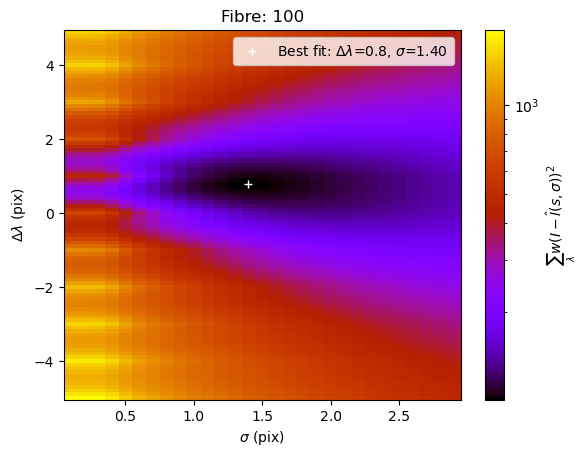

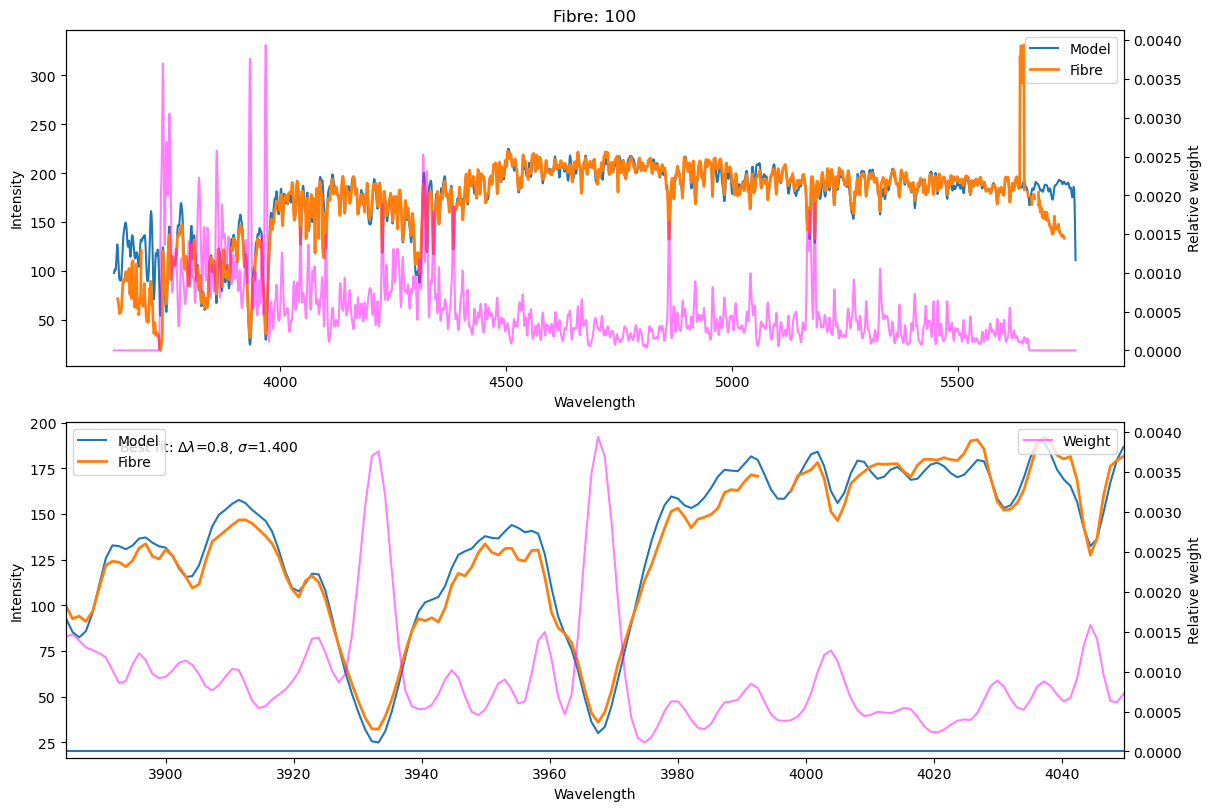

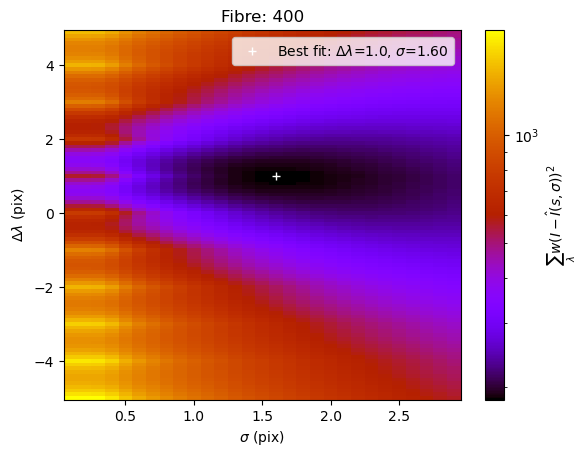

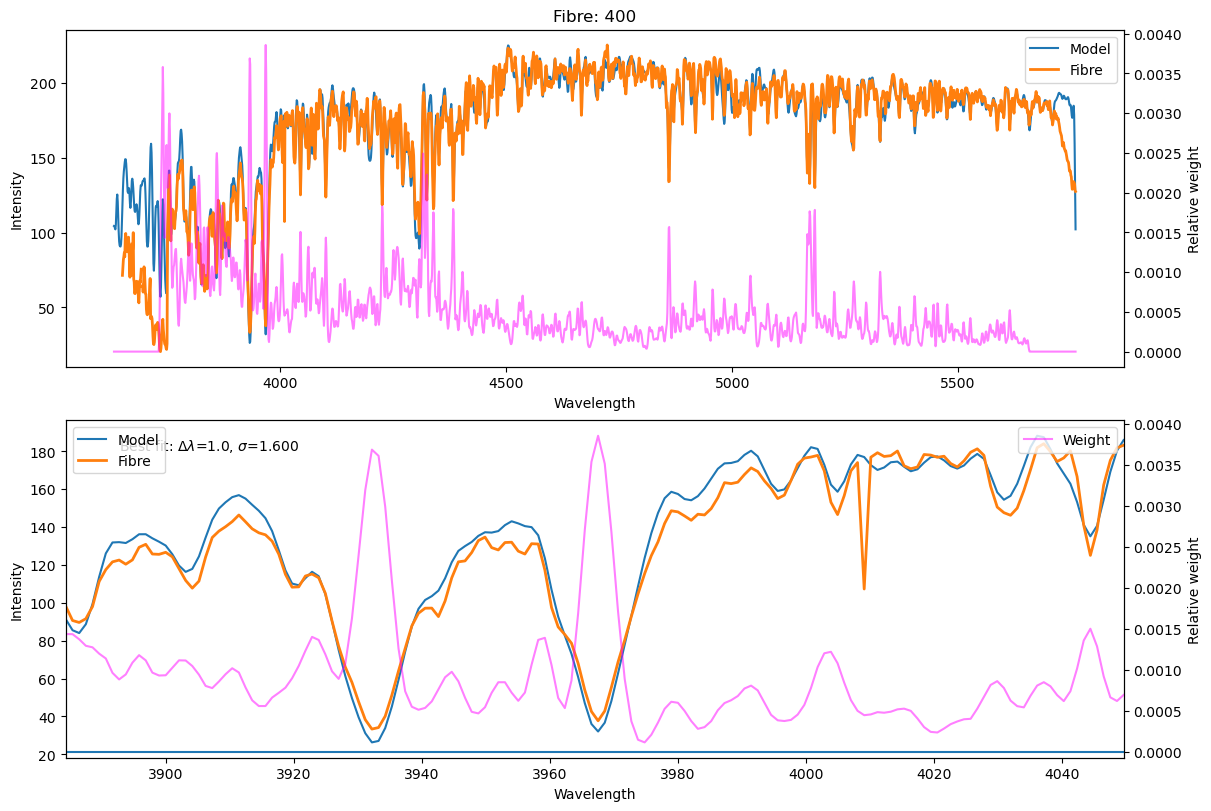

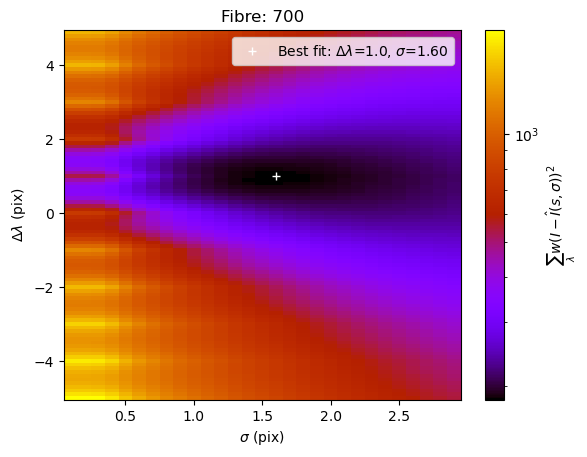

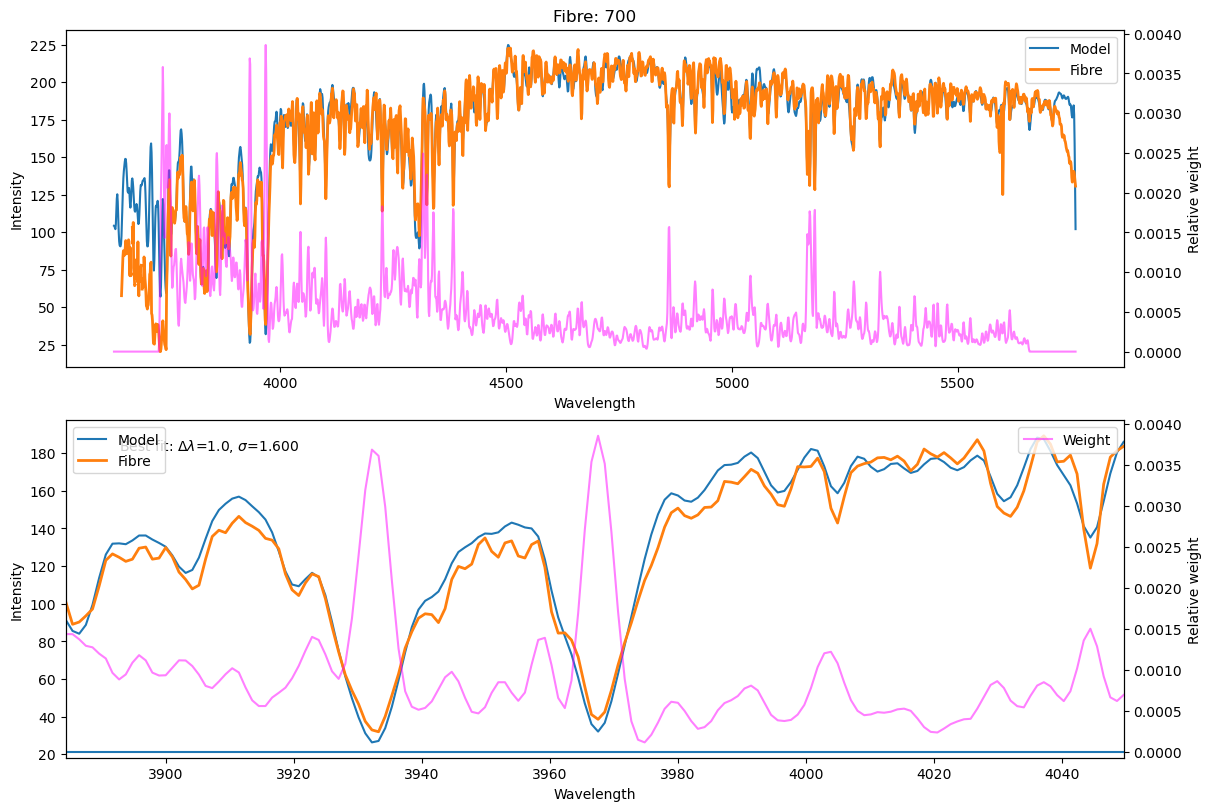

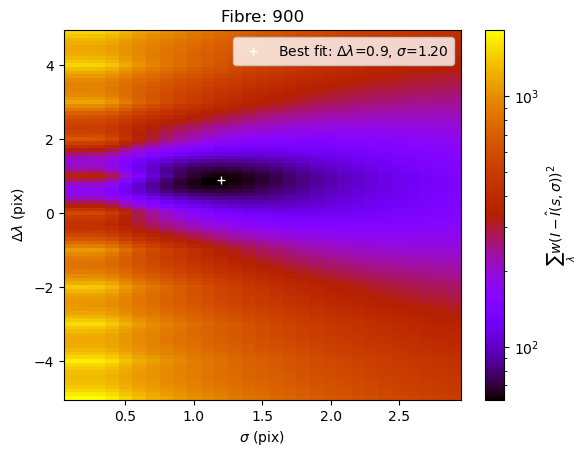

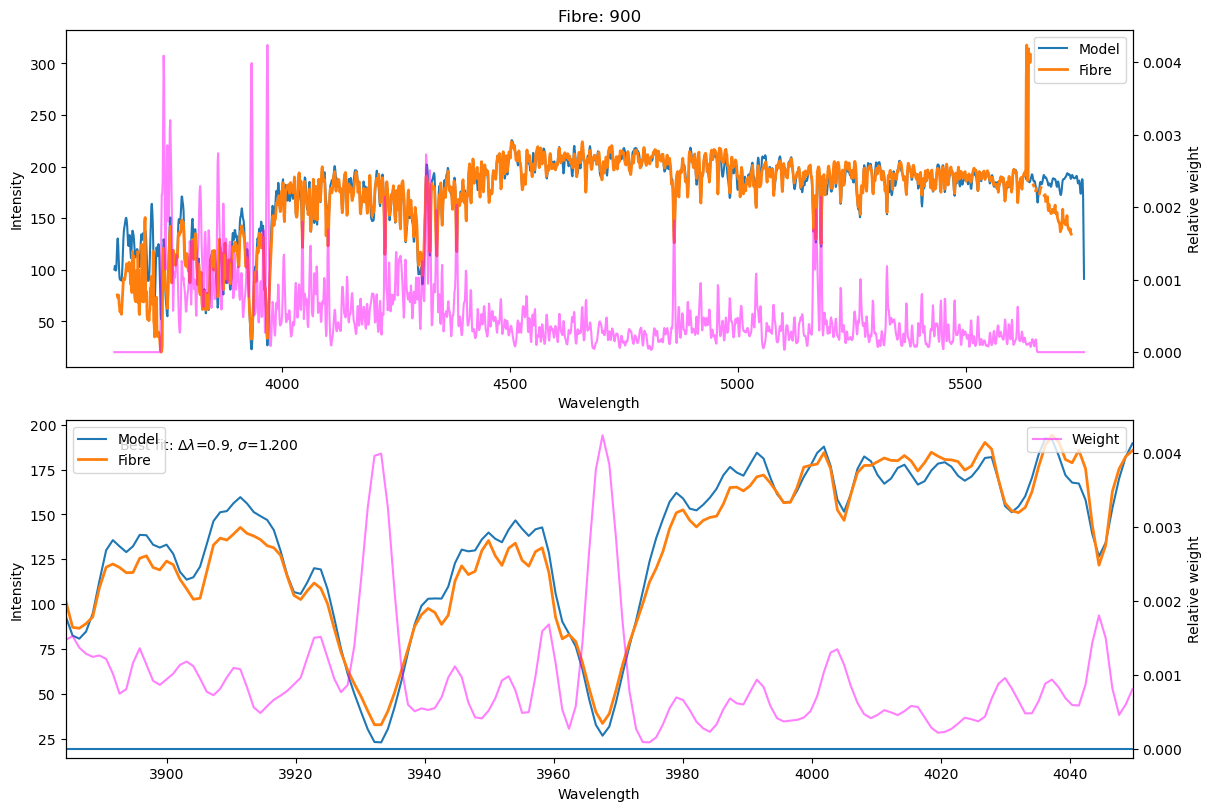

In [4]:
shift, sigma = solar_correction.compute_shift_from_twilight(
    twilight_rss, keep_features_frac=0.05,
    logspace=False, inspect_fibres=[400, 900])

Let's now plot the distribution of offsets as function of fibre location

(<matplotlib.collections.PathCollection at 0x7fd51f6c6590>,
 <matplotlib.colorbar.Colorbar at 0x7fd51f6968d0>)

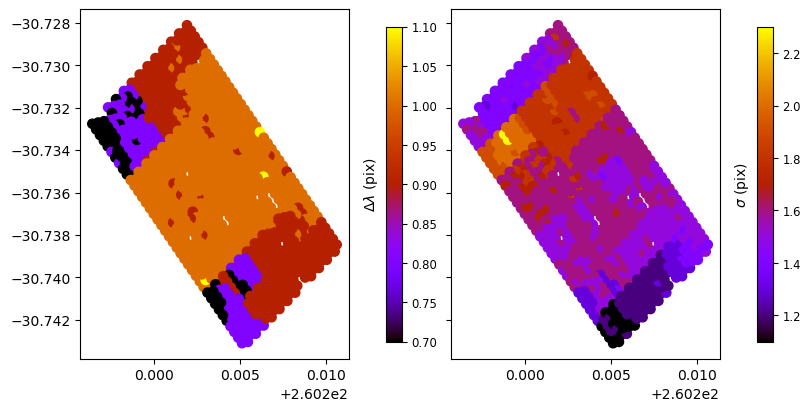

In [5]:
fig, axs = plt.subplots(ncols=2, constrained_layout=True, sharex=True, sharey=True,
                        figsize=(8, 4))
fibre_map(fig, axs[0], r'$\Delta\lambda$ (pix)', twilight_rss, shift, norm=plt.Normalize(),
          cmap='gnuplot')
fibre_map(fig, axs[1], r'$\sigma$ (pix)', twilight_rss, sigma, norm=plt.Normalize(),
          cmap='gnuplot')

If we are happy with the result, we can then correct our RSS data by applying the correction:

In [6]:
twilight_rss_corrected = solar_correction.apply(twilight_rss)

(3923.0, 3943.0)

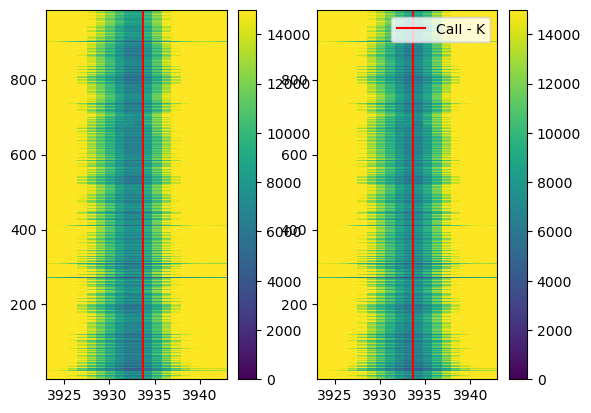

In [10]:
wave_range = [3923, 3943]
vmax = 15000
plt.figure()
plt.subplot(121)
plt.pcolormesh(twilight_rss.wavelength,
               np.arange(1, twilight_rss.intensity.shape[0] + 1),
               twilight_rss.intensity, vmin=0, vmax=vmax)
plt.axvline(3933.663, color='r')
plt.colorbar()
plt.xlim(wave_range)
plt.subplot(122)
plt.pcolormesh(twilight_rss_corrected.wavelength,
               np.arange(1, twilight_rss_corrected.intensity.shape[0] + 1),
               twilight_rss_corrected.intensity, vmin=0, vmax=vmax)
plt.colorbar()
plt.axvline(3933.663, color='r', label='CaII - K')
plt.legend()
plt.xlim(wave_range)